# Exercise 2: Multiple dependent time series

[Forecasting for machine learning](https://www.trainindata.com/p/forecasting-with-machine-learning)

In this notebook we have an exercise to do multiple dependent time series forecasting. The solutions we show are only one way of answering these questions.

Note: Since recording the videos, `skforecast` have made breaking changes to their API in newer versions (>= 0.14). This notebook has been updated for use with `skforecast` version 0.14 and above, which are the versions with a new API. If you are using older versions of `skforecast` (<0.14) see the migration guide here: https://skforecast.org/0.14.0/user_guides/migration-guide.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data preparation

The dataset we shall use is the Quarterly overnight trips (in thousands) from 1998 Q1 to 2016 Q4 across
Australia. The number of trips is split by `State`, `Region`, and `Purpose`. 

**In this exercise we are going to forecast the total number of trips for each State (there are 8 states therefore we will have 8 time series). We shall treat this as a multivariate forecasting problem.**

Source: A new tidy data structure to support
exploration and modeling of temporal data, Journal of Computational and
Graphical Statistics, 29:3, 466-478, doi:10.1080/10618600.2019.1695624.
Shape of the dataset: (24320, 5)

In [2]:
from skforecast.datasets import fetch_dataset

# Load the data
data = fetch_dataset(name="australia_tourism", raw=True)
data.head()

australia_tourism
-----------------
Quarterly overnight trips (in thousands) from 1998 Q1 to 2016 Q4 across
Australia. The tourism regions are formed through the aggregation of Statistical
Local Areas (SLAs) which are defined by the various State and Territory tourism
authorities according to their research and marketing needs.
Wang, E, D Cook, and RJ Hyndman (2020). A new tidy data structure to support
exploration and modeling of temporal data, Journal of Computational and
Graphical Statistics, 29:3, 466-478, doi:10.1080/10618600.2019.1695624.
Shape of the dataset: (24320, 5)


,date_time,Region,State,Purpose,Trips
0,1998-01-01,Adelaide,South Australia,Business,135.077690
1,1998-04-01,Adelaide,South Australia,Business,109.987316
2,1998-07-01,Adelaide,South Australia,Business,166.034687
3,1998-10-01,Adelaide,South Australia,Business,127.160464
4,1999-01-01,Adelaide,South Australia,Business,137.448533


Pre-process the data by performing the following:
1) Convert the `date_time` column to datetime type
2) Create a dataframe with one column per `State` which gives the total number of trips for each date.
3) Ensure the index is `date_time` and resampled to quarterly start `QS`


In [3]:
data["date_time"] = pd.to_datetime(data["date_time"])
data = data.groupby(["date_time", "State"])["Trips"].sum().unstack()
data = data.asfreq("QS")
data.head()

State,ACT,New South Wales,Northern Territory,Queensland,South Australia,Tasmania,Victoria,Western Australia
date_time,,,,,,,,
1998-01-01,551.001921,8039.794795,181.448823,4041.370159,1735.438418,981.629166,6010.424491,1641.089495
1998-04-01,416.025623,7166.013805,313.936151,3967.904653,1394.638319,693.288227,4795.246755,1576.326534
1998-07-01,436.029011,6747.935790,528.436859,4593.893991,1213.330723,401.875275,4316.845170,1588.293692
1998-10-01,449.798445,7282.082371,247.702817,4202.829141,1452.569969,680.601039,4674.829118,1839.716990
1999-01-01,378.572817,7584.776839,184.889592,4332.490850,1541.181791,925.419722,5304.334195,1835.687573


Check for missing values.

In [4]:
data.isnull().any()

State
ACT                   False
New South Wales       False
Northern Territory    False
Queensland            False
South Australia       False
Tasmania              False
Victoria              False
Western Australia     False
dtype: bool

Assign the name of each state to a variable `states`. We will use this later.

In [5]:
states = data.columns

# Exploratory data analysis

Print the number of data points in the time series, the start time, and the end time of the time series.

In [6]:
print(len(data))
print(f"start: {data.index.min()}, end: {data.index.max()}")

80
start: 1998-01-01 00:00:00, end: 2017-10-01 00:00:00


Plot the time series summed over all states.

Text(0.5, 1.0, 'Quartely trips (thousands) - Total')

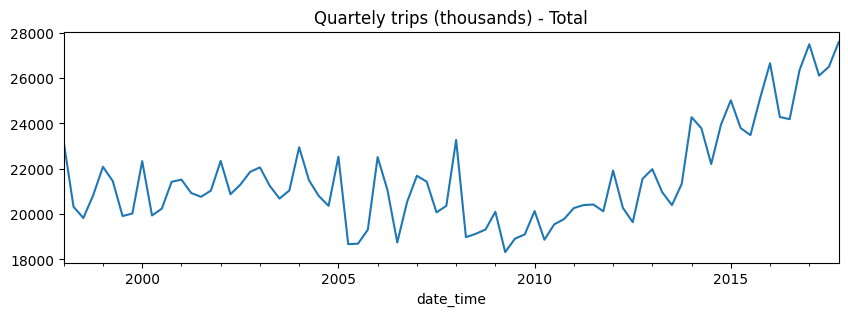

In [7]:
fig, ax = plt.subplots(figsize=[10, 3])
data.sum(axis=1).plot(ax=ax)
ax.set_title("Quartely trips (thousands) - Total")

Plot all of the time series.

Text(0.5, 1.0, 'Quartely trips (thousands)')

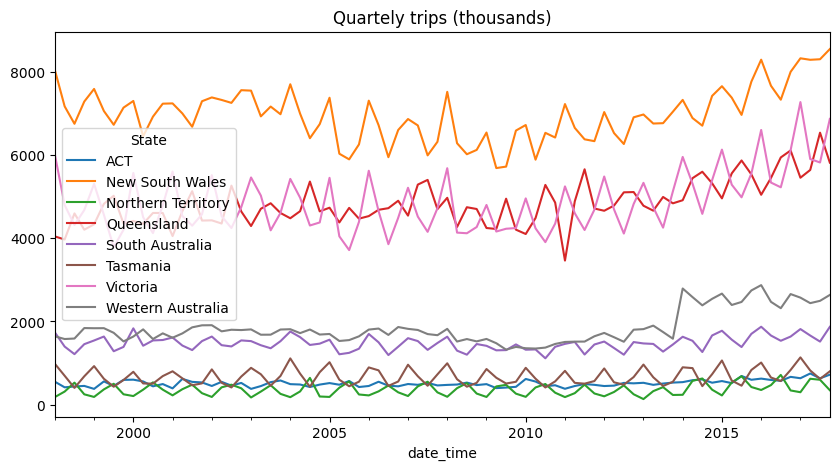

In [8]:
fig, ax = plt.subplots(figsize=[10, 5])
data.plot(ax=ax)
ax.set_title("Quartely trips (thousands)")

It appears that there is yearly seasonality for these series and they appear to be anti-correlated (i.e., some areas experience peaks whilst others experience troughs).

Create a quarter of the year feature which could help with the yearly seasonality.

In [9]:
data["quarter"] = data.index.quarter

# Forecasting

Import the class needed for recursive forecasting for multiple dependent time series from `skforecast`.

In [10]:
from skforecast.direct import ForecasterDirectMultiVariate

Import a transformer from sklearn to scale the data.

In [11]:
# Preprocessing and features
from sklearn.preprocessing import StandardScaler

Import a model of your choice.

In [12]:
# Traditional machine learning models
from sklearn.linear_model import Ridge

Assign the names of the states to a `target_cols` variable and any exogenous features to an `exog_cols` variable.

In [13]:
# Target time series column names
target_cols = states

# Exogenous feature column names
exog_cols = ["quarter"]

Specify a forecast horizon and assign it to a variable `steps`. Try forecasting 8 quarters into the future.

In [14]:
# Forecast horizon: Number of steps to predict
steps = 8

Create a dataframe for the future values of any exogenous features.

Hint: `pd.DateOffset` and using `freq=QS` in `pd.date_range` might be helpful 

In [15]:
# Prepare exogenous features for the future
future_start_date = data.index.max() + pd.DateOffset(months=3)
future_dates = pd.date_range(start=future_start_date, freq="QS", periods=steps + 1)

future_exog = pd.DataFrame(index=future_dates)
future_exog["quarter"] = future_exog.index.quarter

Forecast over each state using a for loop. Define a `ForecasterDirectMultiVariate` forecaster and experiment with the number of lags to use as a feature.

In [16]:
# Loop over each pollutant
results = []
models = dict()

for state in states:

    # Define the forecaster
    forecaster = ForecasterDirectMultiVariate(
        regressor=Ridge(alpha=1),
        level=state,
        lags=12,
        steps=steps,
        transformer_series=StandardScaler(),
        transformer_exog=StandardScaler(),
    )

    # Fit the model
    forecaster.fit(series=data[target_cols], exog=data[exog_cols])

    # Forecast
    forecast = forecaster.predict(steps=steps, exog=future_exog, levels=None)

    models[state] = forecaster
    results.append(forecast)

forecasts = pd.concat(results, axis=1)

Plot the forecasts.

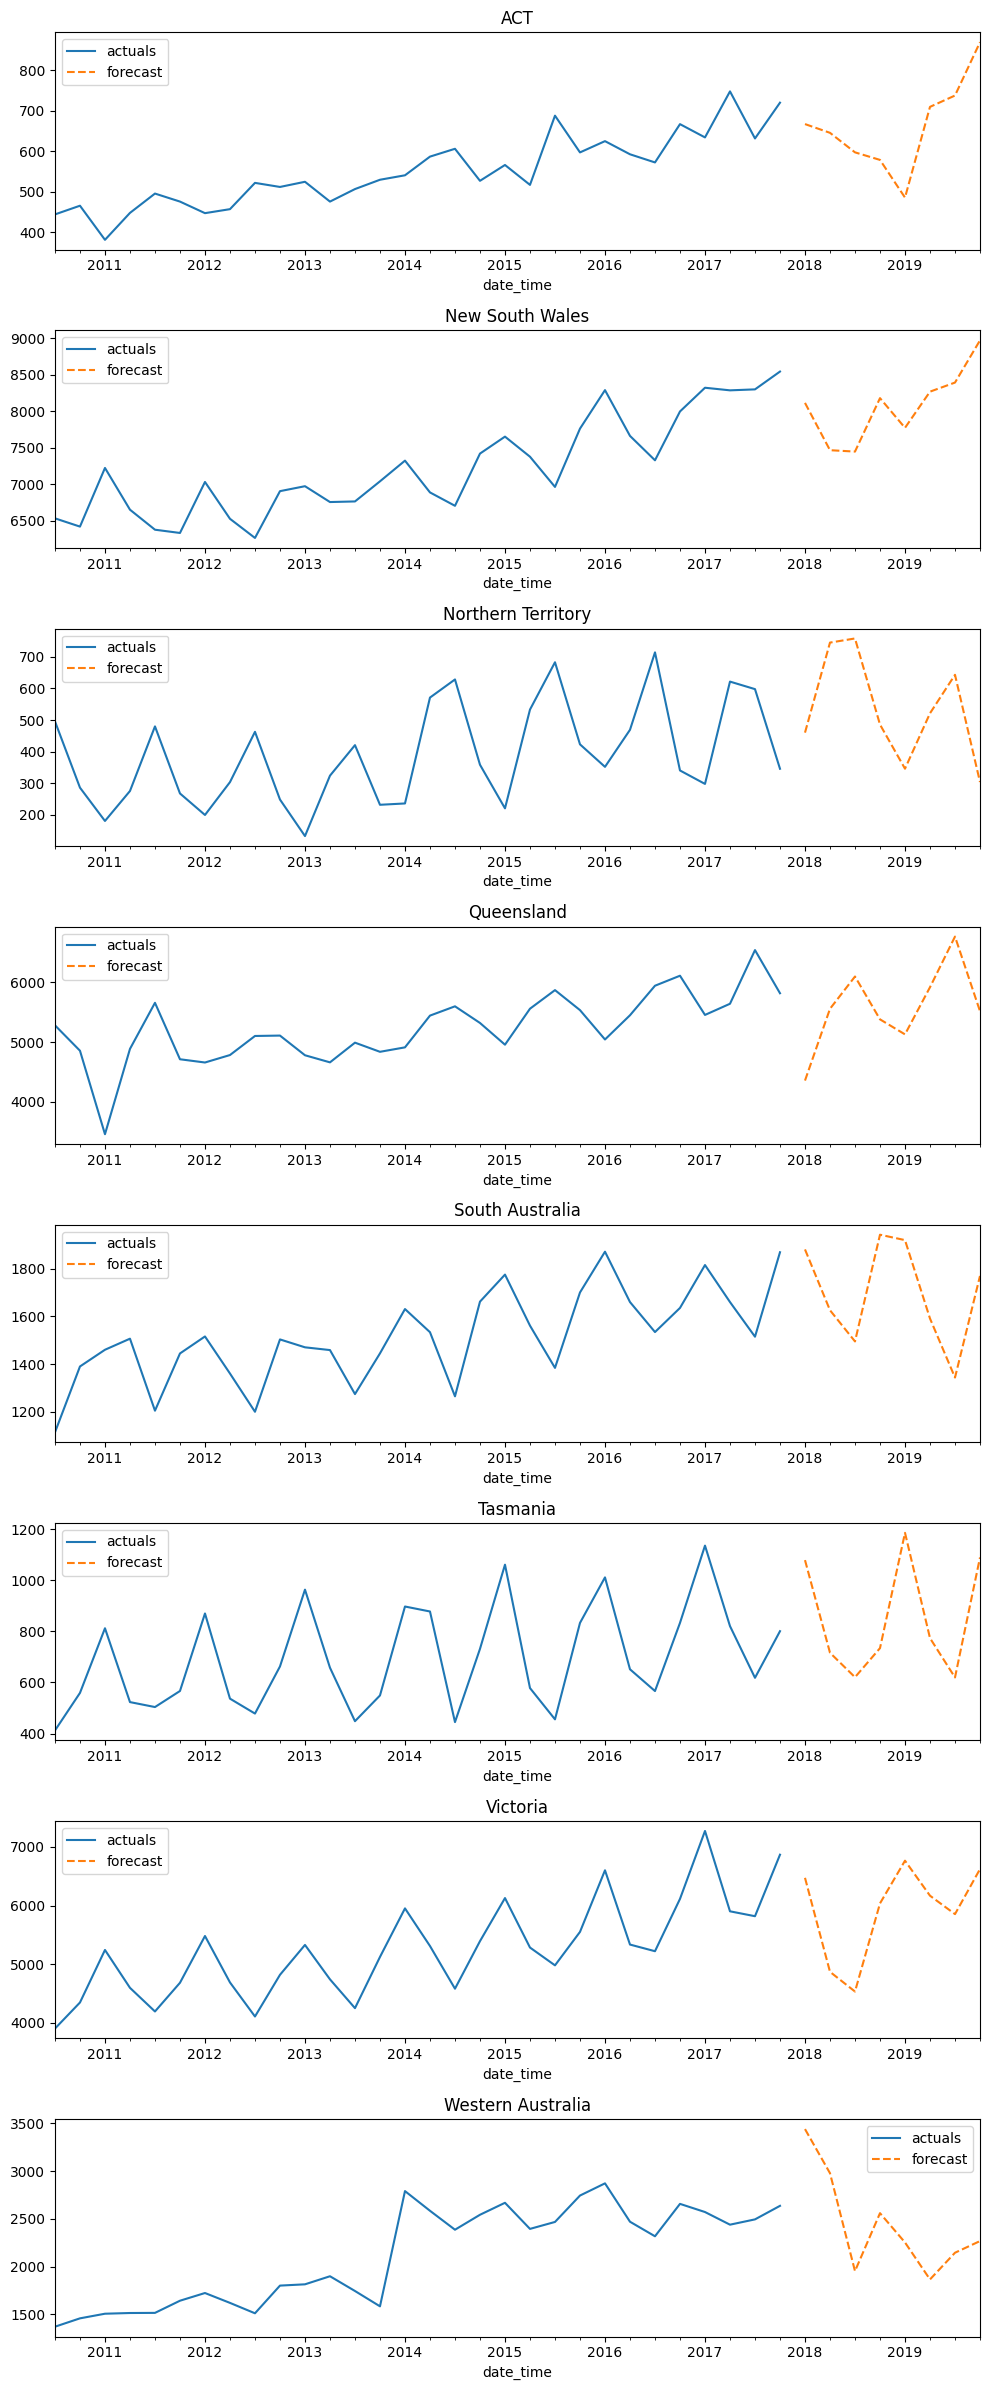

In [17]:
# Plot forecast
num_timeseries = len(states)

# Plotting
fig, axs = plt.subplots(nrows=num_timeseries, figsize=[10, 3 * num_timeseries])
for state, ax in zip(states, axs):

    data.iloc[-30:][state].plot(ax=ax, label="actuals")
    forecasts.loc[:, state].plot(ax=ax, linestyle="--", label="forecast")
    ax.legend()
    ax.set_title(f"{state}")

plt.tight_layout()

<Axes: xlabel='date_time'>

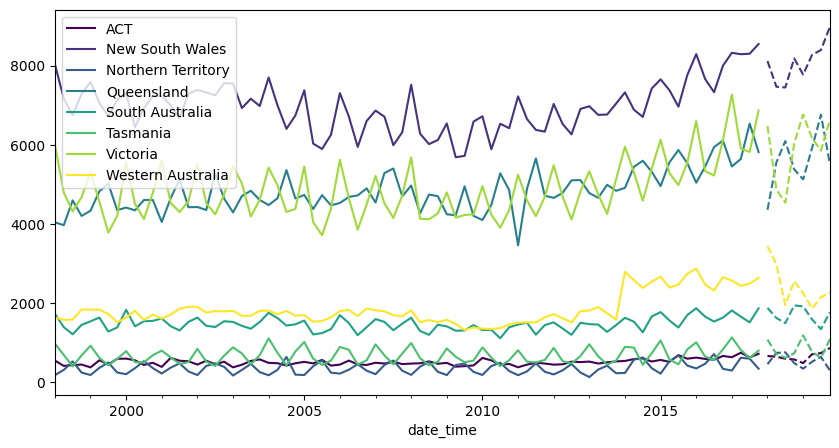

In [18]:
import matplotlib.cm as cm

colors = cm.viridis

fig, ax = plt.subplots(figsize=[10, 5])

past_and_future = pd.concat([data[states], forecasts])

past_dates = data.index
future_dates = forecast.index

past_and_future.loc[past_dates].plot(ax=ax, linestyle="-", cmap=colors)
past_and_future.loc[future_dates].plot(ax=ax, linestyle="--", cmap=colors, legend=False)